In [41]:
import os, time
import shutil
import gzip
import pickle
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

#### Convert the Dataset into pkl.gz

In [29]:
def load_dataset(image_dir, image_size=(64, 64)):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(image_dir))

    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(class_path, filename)
                image_paths.append(filepath)
                labels.append(label_map[class_name])

    images = []
    for path in image_paths:
        img = Image.open(path).convert('L')  # Convert to grayscale
        img = img.resize(image_size)
        images.append(np.array(img).flatten())  # Flatten image

    X = np.array(images, dtype=np.uint8)
    y = np.array(labels, dtype=np.uint8)
    return X, y

def create_dataset_pickle(image_dir, output_path='rice_data.pkl.gz'):
    X, y = load_dataset(image_dir)

    # Split into train, validation, and test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    train_set = (X_train, y_train)
    val_set = (X_val, y_val)
    test_set = (X_test, y_test)

    with gzip.open(output_path, 'wb') as f:
        pickle.dump((train_set, val_set, test_set), f)

    print(f"Dataset saved to {output_path}")

# Usage
image_folder = r"C:\Users\modol\Rice_Image_Dataset"  # Update this path as needed
create_dataset_pickle(image_folder)


Dataset saved to rice_data.pkl.gz


#### Load the RICE datasets 

In [31]:
import gzip
import pickle

with gzip.open('rice_data.pkl.gz', 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]


#### Verify Shape of Dataset

In [34]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (52500, 4096)
Shape of y_train:  (52500,)
Shape of X_validation:  (11250, 4096)
Shape of y_validation:  (11250,)
Shape of X_test:  (11250, 4096)
Shape of y_test:  (11250,)


####    Creat Pandas DataFrames From the datasets 

In [42]:
train_index = range(0,len(X_train))
validation_index = range(len(X_train),
len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),
len(X_train)+len(X_validation)+len(X_test))
X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)
X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)
X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

### Explore the data 

In [43]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
count,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,...,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0,52500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0


In [44]:
y_train.head()

0    1
1    2
2    4
3    3
4    0
dtype: uint8

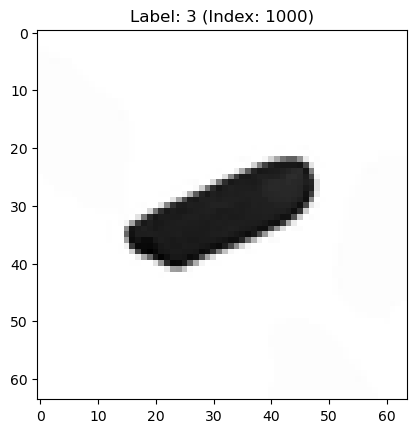

In [51]:
def view_digit(example_index):
    """Visualize a single digit from the training set"""
    # Get the image and label for the specified index
    label = y_train.iloc[example_index]  # Use .iloc for positional indexing
    image = X_train.iloc[example_index, :].values.reshape((64, 64))  # Reshape for 28x28 image
    
    # Plot
    plt.figure()
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title(f"Label: {label} (Index: {example_index})")
    plt.show()

# Example usage - visualize the first training example
view_digit(1000)  # Show the digit at index position 0

### Principal Components Analysis 

In [52]:
from sklearn.decomposition import PCA

In [68]:
n_components = 4096
whiten = False
random_state = 2018
pca = PCA(n_components=n_components, whiten=whiten,
random_state=random_state)

In [69]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [70]:
# Percentage of Variance Captured by 784 principal components
print("Variance Explained by all 4096 principal components: ",
sum(pca.explained_variance_ratio_))

Variance Explained by all 4096 principal components:  1.000000000000001


In [71]:
#Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T
print('Variance Captured by First 10 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values)
print('Variance Captured by First 400 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:399].sum(axis=1).values)
print('Variance Captured by First 500 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:499].sum(axis=1).values)
print('Variance Captured by First 600 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:599].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.70785426]
Variance Captured by First 20 Principal Components:  [0.79723805]
Variance Captured by First 50 Principal Components:  [0.87761011]
Variance Captured by First 100 Principal Components:  [0.92370639]
Variance Captured by First 200 Principal Components:  [0.95625846]
Variance Captured by First 300 Principal Components:  [0.97081403]
Variance Captured by First 400 Principal Components:  [0.97901661]
Variance Captured by First 500 Principal Components:  [0.98432565]
Variance Captured by First 600 Principal Components:  [0.98802771]


######  The first 10 components in total capture approximately 70% of the variance, the 
first one hundred components ove 92%, and the firstsixe hundred component 
almost 99% of the variance; the information in the rest of the princip l
components is of negligible value.

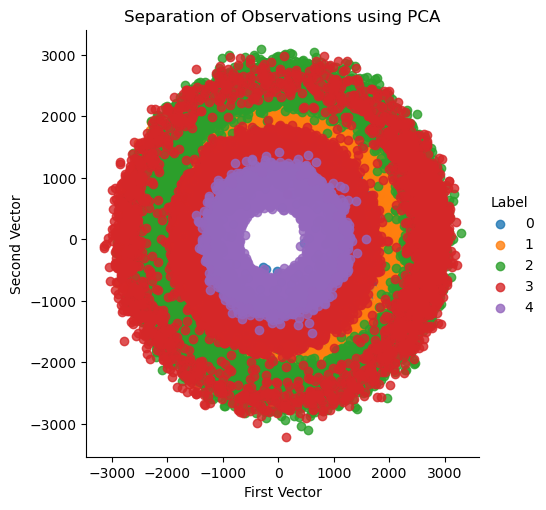

In [79]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", 
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)
scatterPlot(X_train_PCA, y_train, "PCA")


#### Kernel PCA

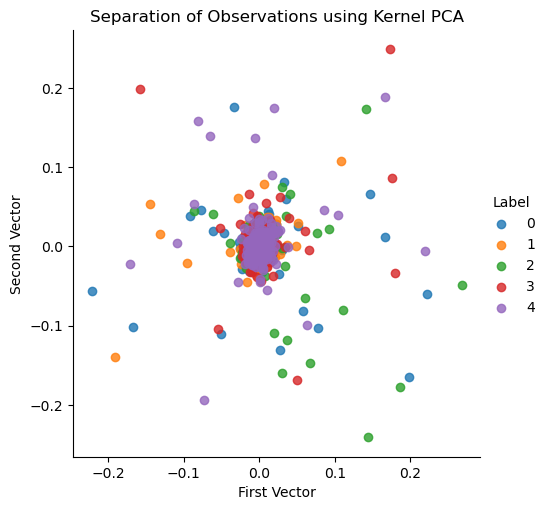

In [95]:
# Kernel PCA
from sklearn.decomposition import KernelPCA
n_components = 600
kernel = 'rbf'
gamma = None
random_state = 2018
n_jobs = 1
kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, n_jobs=n_jobs, random_state=random_state)
kernelPCA.fit(X_train.loc[:3000,:])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=train_index)
X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = pd.DataFrame(data=X_validation_kernelPCA, index=validation_index)
scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

#### Singular Value Decomposition (SVD).

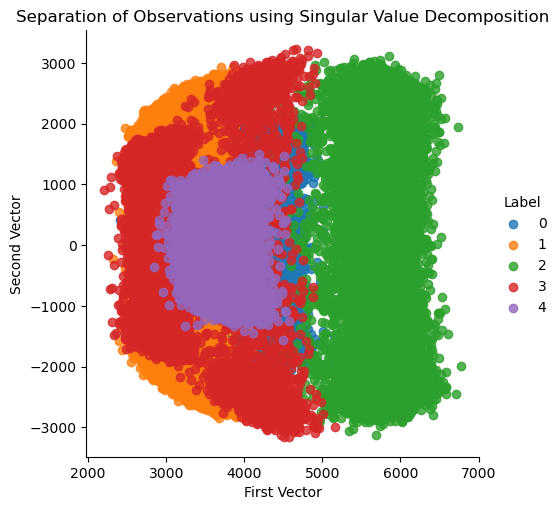

In [84]:
# Singular Value Decomposition
from sklearn.decomposition import TruncatedSVD
n_components = 600
algorithm = 'randomized'
n_iter = 5
random_state = 2018
svd = TruncatedSVD(n_components=n_components, algorithm=algorithm, n_iter=n_iter, random_state=random_state)
X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)
X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd, index=validation_index)
scatterPlot(X_train_svd, y_train, "Singular Value Decomposition")

#### Multidimensional Scaling (MDS)

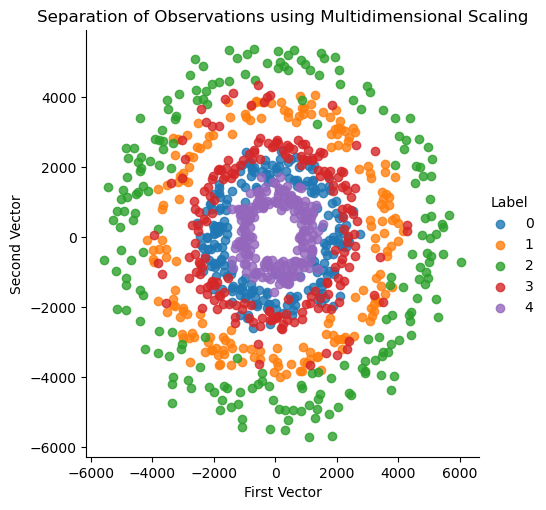

In [86]:
# Multidimensional Scaling
from sklearn.manifold import MDS
n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 2018
mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, \
metric=metric, n_jobs=n_jobs, random_state=random_state)
X_train_mds = mds.fit_transform(X_train.loc[0:1000,:])
X_train_mds = pd.DataFrame(data=X_train_mds, index=train_index[0:1001])
scatterPlot(X_train_mds, y_train, "Multidimensional Scaling")

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

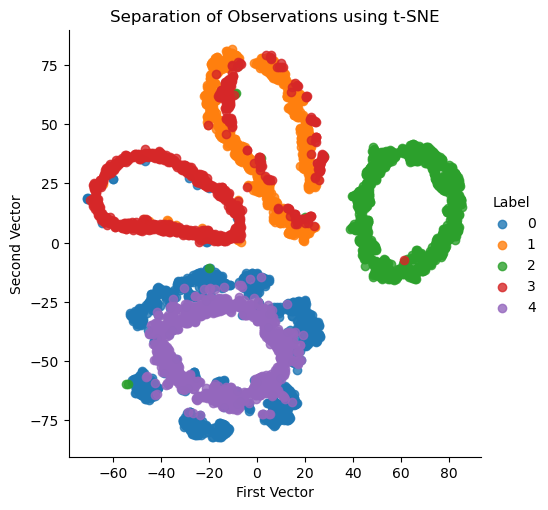

In [89]:
# t-SNE
from sklearn.manifold import TSNE
n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
random_state = 2018
tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, perplexity=perplexity, early_exaggeration=early_exaggeration, init=init, random_state=random_state)
X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[:5001])
scatterPlot(X_train_tSNE, y_train, "t-SNE")

#### Incremental PCA

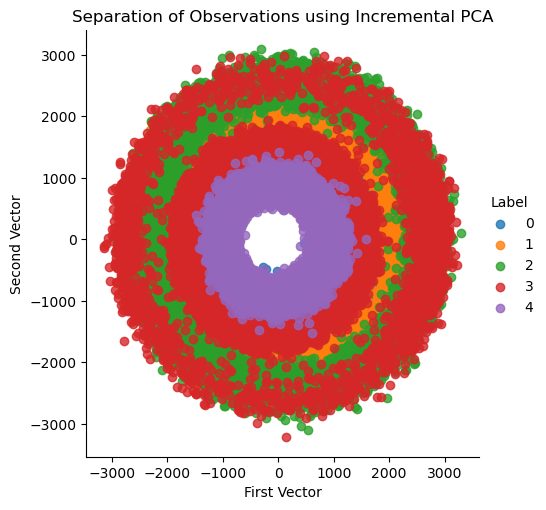

In [96]:
# Incremental PCA
from sklearn.decomposition import IncrementalPCA
n_components = 600
batch_size = None
incrementalPCA = IncrementalPCA(n_components=n_components, batch_size=batch_size)
X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA, index=train_index)
X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA, index=validation_index)
scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")